In [1]:
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

### functions

In [2]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix

def successProbabilityMetric(state1, state2, transition_matrix):
    proba = 0
    for k in range(0, len(transition_matrix)):
        if(k != (state2-1)):
            proba += transition_matrix[state1-1][k]
    return 1-proba

def successScore(sequence, transition_matrix):
    proba = 0
    for i in range(1, len(sequence)):
        if(i==1):
            proba = successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
        else:
            proba = proba*successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
    return proba
        

def anomalyElement(sequence, threshold, transition_matrix):
    if(successScore(sequence, transition_matrix) > threshold):
        return 0
    else:
        return 1

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

## data

In [3]:
df = pd.read_csv("~/Documents/datasets/nab_dataset/realKnownCause/realKnownCause/ambient_temperature_system_failure.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


In [5]:
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [6]:
df['timestamp'].head(10)

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object

In [7]:
df['value'].mean()

71.24243270828815

<AxesSubplot:xlabel='timestamp'>

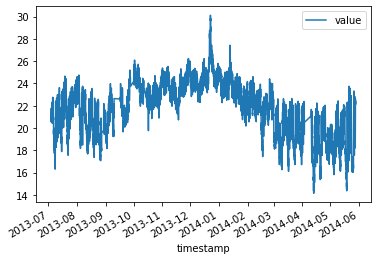

In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5/9
df.plot(x='timestamp', y='value')

## feature

In [9]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay
0,2013-07-04 00:00:00,21.044908,0,0,3,1
1,2013-07-04 01:00:00,21.789015,1,0,3,1
2,2013-07-04 02:00:00,21.598781,2,0,3,1
3,2013-07-04 03:00:00,20.533000,3,0,3,1
4,2013-07-04 04:00:00,20.713084,4,0,3,1
...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1,2,1
7263,2014-05-28 12:00:00,22.318309,12,1,2,1
7264,2014-05-28 13:00:00,22.248092,13,1,2,1
7265,2014-05-28 14:00:00,22.125126,14,1,2,1


In [10]:
outliers_fraction = 0.01

In [11]:
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

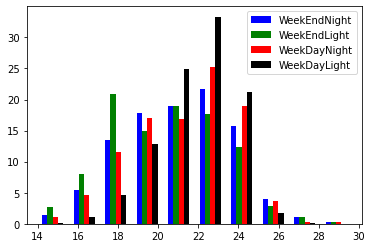

In [12]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

## 2.4 Markov chains

In [13]:
# definition of the different state
x1 = (df['value'] <=18).astype(int)
x2= ((df['value'] > 18) & (df['value']<=21)).astype(int)
x3 = ((df['value'] > 21) & (df['value']<=24)).astype(int)
x4 = ((df['value'] > 24) & (df['value']<=27)).astype(int)
x5 = (df['value'] >27).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5

# getting the anomaly labels for our dataset (evaluating sequence of 5 values and anomaly = less than 20% probable)
# I USE pyemma NOT AVAILABLE IN KAGGLE KERNEL
df_anomaly = markovAnomaly(df_mm, 5, 0.20)
df_anomaly = pd.Series(df_anomaly)
df_anomaly.value_counts()

0    7147
1     120
dtype: int64

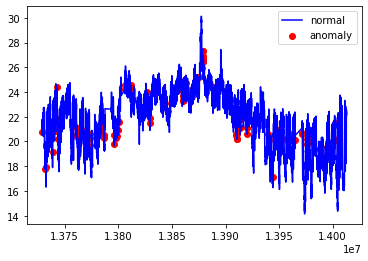

In [14]:
# add the data to the main 
df['anomaly24'] = df_anomaly

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly24'] == 1, ('time_epoch', 'value')] #anomaly


ax.plot(df['time_epoch'], df['value'], color='blue', label='normal') # whole
ax.scatter(a['time_epoch'],a['value'], color='red', label='anomaly') # anomaly
plt.legend()
plt.show()

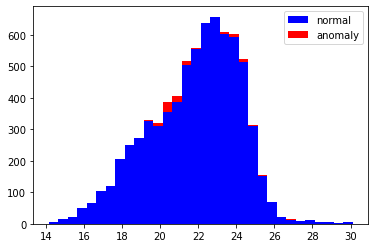

In [15]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly24'] == 0, 'value']
b = df.loc[df['anomaly24'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

## 2.5 Isolation Forest

#### Use for collective anomaly - unordered
collective anomaly (unordered)에 사용  

간단하고, different data repartition에 작동을 잘한다.  

high dimension data에 효과적이다

In [16]:
# useful feature을 모으고, 정규화해준다
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
data

,0,1,2,3,4
0,-0.320586,-1.661537,-1.414798,0.005769,0.62132
1,-0.005228,-1.517172,-1.414798,0.005769,0.62132
2,-0.085851,-1.372807,-1.414798,0.005769,0.62132
3,-0.537536,-1.228442,-1.414798,0.005769,0.62132
4,-0.461215,-1.084077,-1.414798,0.005769,0.62132
...,...,...,...,...,...
7262,0.265532,-0.073523,0.706815,-0.499330,0.62132
7263,0.219090,0.070841,0.706815,-0.499330,0.62132
7264,0.189332,0.215206,0.706815,-0.499330,0.62132
7265,0.137218,0.359571,0.706815,-0.499330,0.62132


In [17]:
#isolation forest 트레이닝한다
model = IsolationForest(contamination = outliers_fraction)
model.fit(data)

#main에 데이터를 추가한다
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1})
df['anomaly25'].value_counts()

0    7194
1      73
Name: anomaly25, dtype: int64

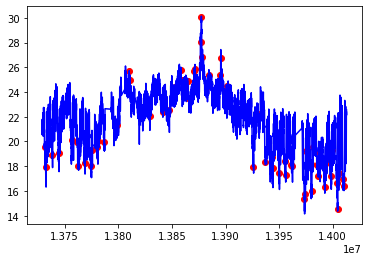

In [18]:
#anomaly visualization - throught time (viz1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'], a['value'], color='red')
plt.show()

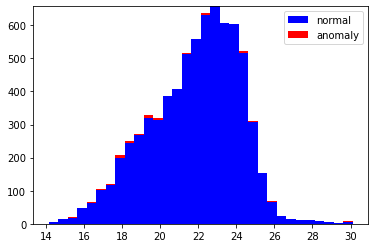

In [19]:
# anomaly visualization - temperature repartition (viz2)
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a, b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

### 2.6. One class SVM

collective anomalies(unordered)에 사용   

novelty detection에 좋다. (train set에 어노멀리가 없는 것)   

multimodal data에 알고리즘이 잘 동작한다

In [21]:
# 유용한 feature을 take하고, 정규화한다
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)

In [ ]:
# train one class SVM
model = OneClassSVM(nu=0.95 * outliers_fraction)